In [1]:
inpickle = 'tablellama/preprocessed.output_temperature_0.1.pickle'

In [ ]:
# for pre in $(ls tablellama/preprocessed.*.pickle); do papermill temperature-measures.ipynb -p inpickle $pre tmp.json; done

In [2]:
prefix, infile = inpickle.split('/')[:2]

In [6]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import swifter
from IPython.display import clear_output

import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

In [7]:
with open(inpickle, 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
answers = mydict['answers']
model_name = mydict['model_name']

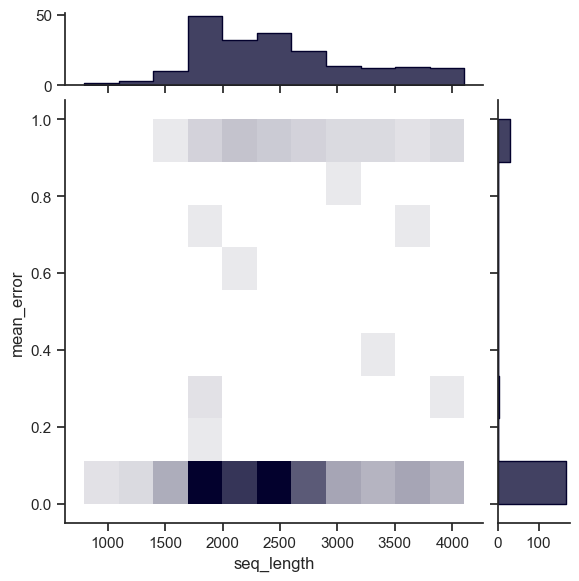

In [8]:
# sequence length vs correctness (check)

test = pd.DataFrame({'seq_length' : segments[segments.run==0].groupby('pid').length.sum(),
              'mean_error' : 1-truth.groupby('pid').correct.mean()})

import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=test, x='seq_length', y='mean_error', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")

In [9]:
truth.groupby('pid').correct.mean().value_counts()

correct
1.0    167
0.0     30
0.7      3
0.3      2
0.8      1
0.4      1
0.6      1
0.1      1
0.2      1
0.9      1
Name: count, dtype: int64

In [10]:
minrun = answers.run.max()
minrun

9

In [11]:
segments.groupby('pid').end.max().mean()

2477.110576923077

In [12]:
gen = segments[segments.segment=='generated']
gen['length'] = gen.end - gen.start

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_93545/3135544532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen['length'] = gen.end - gen.start


In [13]:
gen.groupby('pid').length.max().mean()

24.58173076923077

<Axes: xlabel='correct', ylabel='Count'>

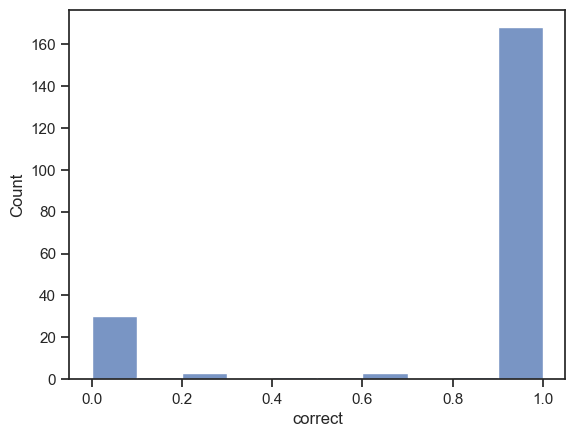

In [14]:
corec = truth.groupby('pid').correct.mean()
sns.histplot(corec, bins=corec.nunique())

In [15]:
corec[(corec!=1.) & (corec!=0.)].shape[0] / corec.shape[0]

0.052884615384615384

In [16]:
# model_name = './gemma-9b-complete/', "google/gemma-2-9b-it"

if model_name.startswith("osunlp"):
    config = transformers.AutoConfig.from_pretrained(model_name)

    orig_ctx_len = getattr(config, "max_position_embeddings", None)
    context_size = 8192
    if orig_ctx_len and context_size > orig_ctx_len:
            scaling_factor = float(math.ceil(context_size / orig_ctx_len))
            config.rope_scaling = {"type": "linear", "factor": scaling_factor}

    tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                              model_max_length=(context_size if context_size > orig_ctx_len else orig_ctx_len),
                                              padding_side="left", 
                                              use_fast=False)

else:
    config = transformers.AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

In [17]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [18]:
# load questions

file_path = "turl_test_2k_prompts_50_unique.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [19]:
%%time

# tokenize inputs

tokenized = []

for idx, p in enumerate(prompts):
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt")
    p['pid'] = idx
    p['prompt'] = prompt
    p['tokenized'] = inputs
    tokenized.append(p)

Token indices sequence length is longer than the specified maximum sequence length for this model (8230 > 8192). Running this sequence through the model will result in indexing errors


CPU times: user 14.1 s, sys: 214 ms, total: 14.4 s
Wall time: 15.9 s


In [20]:
%%time

prompt_lenghts = []

for p in tokenized:
    plen = p['tokenized']['input_ids'][0].shape[0]
    
    cand_len = len(p['question'].split('>,')) - 1
    
    # TODO: check this! (some misalignment can occur )
    cand_pos = [idx for idx, cand in enumerate(p['question'].split('>,')) if p['output'] in cand + '>']
    
    # extract candidates
    candidates = p['question'].split(',. What')[0].split('<')[1:]
    candidates = [c.replace('>,', '').replace('>', '') for c in candidates]
    
    candidates_clean = [c.replace('[DESCRIPTION] ', '').replace('[DESC] ', '').replace('[TYPE] ', '').lower() for c in candidates]
    candidates_clean = [c for c in candidates_clean if c]
    
    candidates_clean_seq = [tokenizer(c, return_tensors="pt")['input_ids'].tolist()[0] for c in candidates_clean]
    
    prompt_lenghts.append((p['pid'], len(p['prompt']), plen, cand_len, cand_pos, candidates, candidates_clean, candidates_clean_seq))

pl = pd.DataFrame(prompt_lenghts, columns=['pid', 'char_len', 'tok_len', 'cand_len', 'cand_pos', 'cand', 'cand_clean', 'cand_clean_seq'])
pl['cand_pos_first'] = pl.cand_pos.str[0]

CPU times: user 8.33 s, sys: 93.1 ms, total: 8.42 s
Wall time: 8.55 s


In [21]:
pl

,pid,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first
0,0,5862,2020,47,[18],"[Murni Discovery Kelana Jaya [DESC] restaurant in Petaling, Selangor, Malaysia [TYPE] restaurant, Templat:S-line/Rel RapidKL...","[murni discovery kelana jaya restaurant in petaling, selangor, malaysia restaurant, templat:s-line/rel rapidkl right/laluan ...","[[1, 286, 595, 29875, 20699, 413, 295, 1648, 432, 9010, 27144, 297, 5697, 12818, 29892, 5535, 574, 272, 29892, 4439, 1036, 4...",18
1,1,6252,1959,49,[42],"[nakfa [DESC] currency of Eritrea [TYPE] currency, Coastal Eritrea [DESC] None [TYPE] None, Template:Regions of Eritrea [DES...","[nakfa currency of eritrea currency, coastal eritrea none none, template:regions of eritrea wikimedia template wikimedia tem...","[[1, 23349, 5444, 27550, 310, 604, 277, 5638, 27550], [1, 12180, 284, 604, 277, 5638, 5642, 5642], [1, 4472, 29901, 1727, 10...",42
2,2,7082,2340,48,[20],[David R. Macdonald Papers (NAID 649130) [DESC] collection in the National Archives and Records Administration's holdings [T...,[david r. macdonald papers (naid 649130) collection in the national archives and records administration's holdings collectio...,"[[1, 13260, 333, 364, 29889, 5825, 9176, 2741, 15055, 313, 1056, 333, 29871, 29953, 29946, 29929, 29896, 29941, 29900, 29897...",20
3,3,8320,2800,48,[28],"[Santa Inés [DESC] None [TYPE] None, Antonio Delfino [DESC] Wikimedia list article [TYPE] cargo liner, Delfino [DESC] attack...","[santa inés none none, antonio delfino wikimedia list article cargo liner, delfino attack submarine attack submarine, doña i...","[[1, 269, 6949, 297, 743, 5642, 5642], [1, 385, 880, 601, 628, 29888, 1789, 281, 638, 3393, 1051, 4274, 17040, 301, 4983], [...",28
4,4,5769,1930,48,[17],"[The Ink Pots [DESC] None [TYPE] painting, Pots Lake [DESC] lake in Oscoda County, Michigan, United States of America [TYPE]...","[the ink pots none painting, pots lake lake in oscoda county, michigan, united states of america lake, cream pots location i...","[[1, 278, 297, 29895, 282, 1862, 5642, 20413], [1, 282, 1862, 19437, 19437, 297, 15199, 8887, 15178, 29892, 21488, 11163, 29...",17
...,...,...,...,...,...,...,...,...,...
1796,1796,11209,4547,49,[36],"[Leda [DESC] mythical character [TYPE] mythological Greek character, Charis [DESC] given name [TYPE] unisex given name, Eudo...","[leda mythical character mythological greek character, charis given name unisex given name, eudoros greek mythical character...","[[1, 454, 1388, 22082, 936, 2931, 22082, 5996, 330, 7285, 2931], [1, 1373, 275, 2183, 1024, 443, 275, 735, 2183, 1024], [1, ...",36
1797,1797,19295,5372,51,[31],[The Supernova 1987A Shows a Mind of Its Own--and a Burst of Neutrinos: The first nearby supernova in 400 years continues to...,[the supernova 1987a shows a mind of its own--and a burst of neutrinos: the first nearby supernova in 400 years continues to...,"[[1, 278, 2428, 29876, 4273, 29871, 29896, 29929, 29947, 29955, 29874, 3697, 263, 3458, 310, 967, 1914, 489, 392, 263, 20887...",31
1798,1798,11485,2888,49,[0],"[Tocumen International Airport [DESC] international airport in Panama City, Panama [TYPE] airport, El Dorado Springs Memoria...","[tocumen international airport international airport in panama city, panama airport, el dorado springs memorial airport airp...","[[1, 304, 29883, 14170, 6121, 4799, 637, 6121, 4799, 637, 297, 7243, 3304, 4272, 29892, 7243, 3304, 4799, 637], [1, 560, 166...",0
1799,1799,10637,2716,48,[47],"[Gardiner [DESC] container ship built in 2003 [TYPE] container ship, Cape Town Stadium [DESC] sports stadium in Cape Town, S...","[gardiner container ship built in 2003 container ship, cape town stadium sports stadium in cape town, south africa multi-pur...","[[1, 17161, 4983, 5639, 7751, 4240, 297, 29871, 29906, 29900, 29900, 29941, 5639, 7751], [1, 274, 4085, 4726, 10728, 1974, 1...",47


In [26]:
def cleanone(string):
    if not string: return None
    return string.replace('[DESCRIPTION]', '[DESC]').replace('<', '').replace('>', '').lower()

a = answers.merge(pl, on='pid', how='left')
a['reconstructed'] = a.apply(lambda row: row['cand'][row['cand_pos_first']], axis=1)

a['reconstructed_correct'] = (a.answer.str.replace('[DESCRIPTION]', '[DESC]').str.lower() == a.reconstructed.str.lower())
a['correct'] = (a.answer.apply(cleanone) == a.right_answer.apply(cleanone))


In [47]:
def cleanup_before_she_comes(mystr):
    if not mystr: return None
    mystr = mystr.lower().replace('[desc] ', '').replace('[description] ', '').replace('[type] ', '')
    # if ']' in mystr or '[' in mystr: print(mystr)
    return mystr

a['answer_clean'] = a.answer.apply(lambda x: cleanup_before_she_comes(x)).str.replace('<', '').str.replace('>', '')
a['right_answer_clean'] = a['right_answer'].str.replace('[description] ', '').str.replace('[desc] ', '').str.replace('[type] ', '').str.replace('<', '').str.replace('>', '')
a['regex_match_clean'] = a.regex_match.apply(lambda x: cleanup_before_she_comes(x)).str.replace('<', '').str.replace('>', '')

In [48]:
a

,run,pid,answer,answer_seq,right_answer,regex_match,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first,reconstructed,reconstructed_correct,correct,answer_clean,right_answer_clean,regex_match_clean
0,0,872,ifuleave [desc] 2008 single by musiq soulchild [type] single,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<ifuleave [desc] 2008 single by musiq soulchild [type] single>,ifuleave [desc] 2008 single by musiq soulchild [type] single,5867,1930,46,[40],"["" Brand im Osten "" [DESC] painting by O. Bloss/Eisfeld [TYPE] painting, High school ""Ivan Vazov"" [DESC] school in Bulgaria ...","["" brand im osten "" painting by o. bloss/eisfeld painting, high school ""ivan vazov"" school in bulgaria school, оу "" иван ваз...","[[1, 376, 14982, 527, 288, 3510, 376, 20413, 491, 288, 29889, 1999, 2209, 29914, 29872, 4492, 2495, 20413], [1, 1880, 3762, ...",40,IfULeave [DESC] 2008 single by Musiq Soulchild [TYPE] single,True,True,ifuleave 2008 single by musiq soulchild single,ifuleave 2008 single by musiq soulchild single,ifuleave 2008 single by musiq soulchild single
1,1,872,ifuleave [desc] 2008 single by musiq soulchild [type] single,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<ifuleave [desc] 2008 single by musiq soulchild [type] single>,ifuleave [desc] 2008 single by musiq soulchild [type] single,5867,1930,46,[40],"["" Brand im Osten "" [DESC] painting by O. Bloss/Eisfeld [TYPE] painting, High school ""Ivan Vazov"" [DESC] school in Bulgaria ...","["" brand im osten "" painting by o. bloss/eisfeld painting, high school ""ivan vazov"" school in bulgaria school, оу "" иван ваз...","[[1, 376, 14982, 527, 288, 3510, 376, 20413, 491, 288, 29889, 1999, 2209, 29914, 29872, 4492, 2495, 20413], [1, 1880, 3762, ...",40,IfULeave [DESC] 2008 single by Musiq Soulchild [TYPE] single,True,True,ifuleave 2008 single by musiq soulchild single,ifuleave 2008 single by musiq soulchild single,ifuleave 2008 single by musiq soulchild single
2,2,872,ifuleave [desc] 2008 single by musiq soulchild [type] single,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<ifuleave [desc] 2008 single by musiq soulchild [type] single>,ifuleave [desc] 2008 single by musiq soulchild [type] single,5867,1930,46,[40],"["" Brand im Osten "" [DESC] painting by O. Bloss/Eisfeld [TYPE] painting, High school ""Ivan Vazov"" [DESC] school in Bulgaria ...","["" brand im osten "" painting by o. bloss/eisfeld painting, high school ""ivan vazov"" school in bulgaria school, оу "" иван ваз...","[[1, 376, 14982, 527, 288, 3510, 376, 20413, 491, 288, 29889, 1999, 2209, 29914, 29872, 4492, 2495, 20413], [1, 1880, 3762, ...",40,IfULeave [DESC] 2008 single by Musiq Soulchild [TYPE] single,True,True,ifuleave 2008 single by musiq soulchild single,ifuleave 2008 single by musiq soulchild single,ifuleave 2008 single by musiq soulchild single
3,3,872,ifuleave [desc] 2008 single by musiq soulchild [type] single,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<ifuleave [desc] 2008 single by musiq soulchild [type] single>,ifuleave [desc] 2008 single by musiq soulchild [type] single,5867,1930,46,[40],"["" Brand im Osten "" [DESC] painting by O. Bloss/Eisfeld [TYPE] painting, High school ""Ivan Vazov"" [DESC] school in Bulgaria ...","["" brand im osten "" painting by o. bloss/eisfeld painting, high school ""ivan vazov"" school in bulgaria school, оу "" иван ваз...","[[1, 376, 14982, 527, 288, 3510, 376, 20413, 491, 288, 29889, 1999, 2209, 29914, 29872, 4492, 2495, 20413], [1, 1880, 3762, ...",40,IfULeave [DESC] 2008 single by Musiq Soulchild [TYPE] single,True,True,ifuleave 2008 single by musiq soulchild single,ifuleave 2008 single by musiq soulchild single,

In [85]:
# aggregate answer text and embeddings per each prompt
ac = a.groupby('pid')['answer_clean'].apply(list).reset_index()

# candidates
ace3 = a.groupby('pid')['cand_clean'].apply(lambda x: list(x)[0]).reset_index()

# regex match
ace4 = a.groupby('pid')['regex_match_clean'].apply(lambda x: list(x)).reset_index()

In [86]:
ac = ac.merge(ace3, on='pid').merge(ace4, on='pid')

In [87]:
# entropy of answers
from scipy.stats import entropy
from collections import Counter

ac['num_answers'] = ac.apply(lambda x: len(set(x.answer_clean)), axis=1)

ac['answers_freqs'] = ac.apply(lambda x: list(Counter(x.answer_clean).values()), axis = 1)
ac['answers_entropy'] = ac.apply(lambda x: entropy(x.answers_freqs), axis = 1)
ac['answers_entropy_norm'] = ac.apply(lambda x: x.answers_entropy / max(1, np.log2(len(x.answers_freqs))), axis = 1)

In [88]:
(ac.answers_freqs.str.len() == ac.num_answers).sum() == ac.shape[0]

True

In [89]:
ac['regex_match_freqs'] = ac.apply(lambda x: list(Counter(x.regex_match_clean).values()), axis = 1)
ac['regex_match_entropy'] = ac.apply(lambda x: entropy(x.regex_match_freqs), axis = 1)
ac['regex_match_entropy_norm'] = ac.apply(lambda x: x.regex_match_entropy / max(1, np.log2(len(x.regex_match_freqs))), axis = 1)

In [90]:
ac.answers_entropy_norm.value_counts()

answers_entropy_norm
0.000000    196
0.610864      5
0.325083      3
0.500402      2
0.673012      2
Name: count, dtype: int64

In [91]:
ac.regex_match_entropy_norm.value_counts()

regex_match_entropy_norm
0.000000    197
0.610864      5
0.500402      2
0.673012      2
0.325083      2
Name: count, dtype: int64

In [92]:
aggro = a.groupby('pid').agg({'correct': 'mean'})

In [93]:
aggrodue = ac.merge(aggro.reset_index(), on='pid', how='inner')

In [46]:
with open(prefix + '/' + infile.replace('preprocessed', 'aggregated'), 'wb') as handle:
    pickle.dump(aggrodue, handle, protocol=pickle.HIGHEST_PROTOCOL)